## Find Lane Lines on Road
****

This uses simple computer vision techinques to identify lanes lines in images or videos from car driving along the road. Identifying the lane lines will help a self driving car identify the boundaries within which it needs to operate.

A pipeline is developed that takes every image through a series of steps to identify the lanes:
    
   1. Take the image and convert it into Grayscale
   2. Apply Gaussian smoothing
   3. Detect edges using Canny edge detection
   4. Extract edges in a region of interest where the lane is expected to be
   5. Use Hough transforms to find lane lines
   6. Extend lane lines to identify the boundaries of the lane
   6. Overlay the lanes edges on the initial image   


#### Import packages

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import numpy.polynomial.polynomial as poly
%matplotlib inline

#### Read in test image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


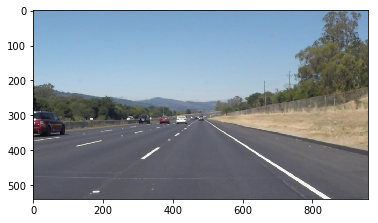

In [14]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#### Helper functions for various steps in the pipeline

In [15]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
        
#    for line in lines:
#        for x1,y1,x2,y2 in line:
#            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    #print(lines.shape)
    lines = lines.reshape(lines.shape[0], lines.shape[2])
    #print("lines.shape: ",lines.shape)
    
    # slope = (y2-y1)/(x2-x1)
    slopes = (lines[:,3]-lines[:,1])/(lines[:,2] - lines[:,0])
    
    #print("slopes.shape", slopes.shape)
    
    # If any of the slopes are inf, set them to zero (we ignore zero slopes)
    slopes[np.isinf(slopes)]=0
    slopes = slopes.reshape(slopes.shape[0])
    
    #print("slopes.reshape: ",slopes.shape)
     
    """
    Extract the left lane line points and draw it on the image
    """
    # Parameters
    slope_threshold = 0.5# slopes below which to reject the lines (too flat to be a lane line)
    n=2 # order of polynomial to fit through the points
    
        
    left_line_points = lines[slopes<(-slope_threshold),:]
    left_line_points = np.vstack((left_line_points[:,[0,1]], left_line_points[:,[2,3]]))
    #left_slopes = slopes[slopes<slope_threshold]
    #print(np.mean(left_slopes))
    #print("left_line_points shape: ",left_line_points.shape)
    #print(slopes>slope_threshold)
    
    if left_line_points.shape[0] > 0:
        # Ends of left line points
        left_min = np.amin(left_line_points, axis=0)
        left_max = np.amax(left_line_points, axis=0)

        # Fit an nth order polynomial curve through the left line points
        left_line_poly = poly.polyfit(left_line_points[:,1], left_line_points[:,0], n) # get the coeffs of the poly
        left_line_fit = poly.polyval(left_line_points[:,1], left_line_poly) # x= f(y), where y is the existing left line point_y
        #left_line_fit = left_line_fit.reshape(left_line_fit.shape[0],1)# reshape to 1d vector
        #left_line_fit = (np.flip(left_line_fit,0)).astype(int) #flip to line up with the left line points and covert to int to be able draw on the image
        #left_line_fit = np.hstack((left_line_fit[:,[0]],left_line_points[:,[1]])) # [x_fit,y_line]
    
        # Get intercept of left line with bottom of image and left_min(y)
        left_line_bottom_x = int(poly.polyval(img.shape[0], left_line_poly))
        left_line_top_x = int(poly.polyval(left_min[1],left_line_poly))
        
        # Draw left line
        cv2.line(img, (left_line_bottom_x, img.shape[0]), (left_line_top_x, left_min[1]), color, thickness)
       
    """
    Extract the right lane line points and draw it on the image
    """
    right_line_points = lines[slopes>slope_threshold,:]
    right_line_points = np.vstack((right_line_points[:,[0,1]], right_line_points[:,[2,3]]))    
    #print(lines.shape)
    #print(right_line_points.shape)
    #print(slopes>slope_threshold)
    #print(slopes)
    # Limits 
    if right_line_points.shape[0] > 0:
        right_min = np.amin(right_line_points, axis=0)
        right_max = np.amax(right_line_points, axis=0)
    
        # Fit an nth order polynomial curve through the left line points
        right_line_poly = poly.polyfit(right_line_points[:,1], right_line_points[:,0], n) # get the coeffs of the poly
        right_line_fit = poly.polyval(right_line_points[:,1], right_line_poly) # x= f(y), where y is the existing right line point_y
    
        # Get intercept of left line with bottom of image
        right_line_bottom_x = int(poly.polyval(img.shape[0], right_line_poly))
        right_line_top_x = int(poly.polyval(right_min[1], right_line_poly))
        # Draw right line
        #cv2.line(img, (right_min[0], right_min[1]), (right_max[0], right_max[1]), color, thickness)
        cv2.line(img, (right_line_bottom_x, img.shape[0]), (right_line_top_x, right_min[1]), color, thickness) 
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Lane Finding Pipeline

Build a pipeline that takes in image from a car and goes the various steps to return  

In [16]:
def process_image(image):
    """
    Input: image from a camera pointed out the windshield of a car showing its lane
    
    Takes an image and extract the current lane lines out of it using the following steps:
    1. Grayscale the image
    2. Apply Gaussian smoothing
    3. Detect edges using Canny edge detection
    4. Extract edges in a region of interest
    5. Use Hough transforms to find lane lines and draw it on a blank image
    6. Overlay the lanes edges on the initial image   
    
    Output: The initial image with the lanes identified and overlayed on the image
    """
    
    """
    Grayscale the image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

    """
    Define a kernel size and apply Gaussian smoothing
    """
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    """
    Detect the edges in the image using Canny Edge Detection
    """
    # Define parameters for Canny edge detection and apply
    low_threshold = 100
    high_threshold = 200
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    """
    Extract region of interest from the image
    Using a four sided polygon as a mask
    """
    img_shape = edges.shape
    vertices = np.array([[(50,img_shape[0]),(450, 320), (550, 320), (900,img_shape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    assert(masked_edges.shape == img_shape)
    """
    Use Hough transform to find lane lines from Canny edges in the region of interest
    Draw the lane lines on a blank image which is the same size as the initial image
    """
    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    """
    Overlay the line image on the original image and display the resulting image
    """
    assert(image.shape == line_image.shape)
    image_with_lane_lines = weighted_img(line_image, image, 0.8, 1, 0)
    
    return image_with_lane_lines    


### Test Images

Run the pipeline on each of the images and identify the lane lines. Draw the lane boundaries overlayed on the image

In [17]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg']

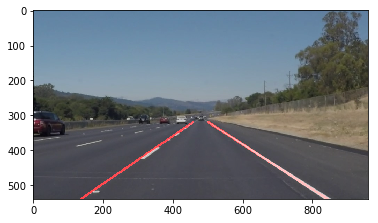

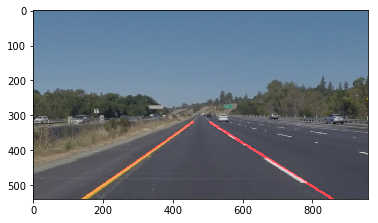

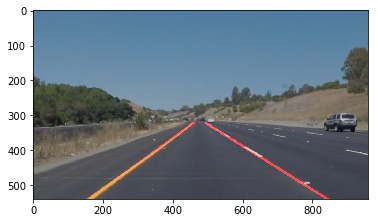

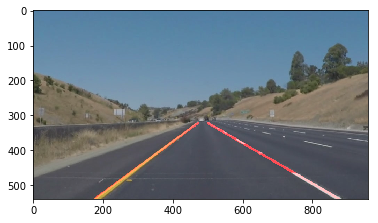

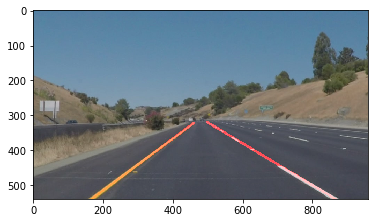

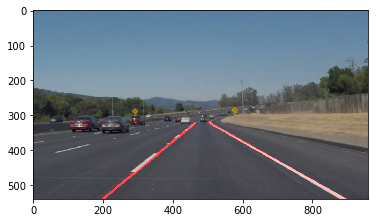

In [26]:
    """
    Select test images to find lane lines by setting a value from 0-1
    Display the image with the lane lines overlayed on top
    """
    list_of_images = os.listdir("test_images")
    for image_select in list_of_images:
        #image_select = list_of_images[image_to_test]
        image = mpimg.imread("./test_images/" + image_select)
        # Run the image through the pipeline
        image_with_lane_lines = process_image(image)
        # Display the initial image with the lane lines marked out
        plt.imshow(image_with_lane_lines)
        plt.show()


### Test Videos

Now run the pipeline on a video taken from the car driving on the road

First video with the solid white line on the right

Second video with the solid yellow line to the left

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 31.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 46.9 s, sys: 464 ms, total: 47.3 s
Wall time: 7.53 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [31]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:24<00:00, 23.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 40s, sys: 1.45 s, total: 2min 42s
Wall time: 25.4 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

#### Challenge Video

Need to tweak the pipeline to work on the challenge video!

In [35]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
##clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 99%|█████████▉| 125/126 [00:06<00:00, 19.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 41.3 s, sys: 372 ms, total: 41.6 s
Wall time: 7.22 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))